Codigo donde haremos el analisis exploratorio de los datos para elegir aquellos que utilizaremos en nuestro sistema de recomendacion de peliculas con el modelo de similitud de coseno, ejecutaremos el modelo y crearemos el dataset con las 5 peliculas recomendadas por titulo

In [1]:
import pandas as pd

# Configuración para mostrar todas las filas
pd.set_option('display.max_rows', None)

In [2]:
#Creamos una funcion para evaluar tipo de datos, porcentaje de nulos y cantidad de valores unicos en el dataset
def resumen(df):
    print(f'data shape: {df.shape}')
    resumen = pd.DataFrame(df.dtypes, columns=['data type'])
    resumen['#missing'] = df.isnull().sum()
    resumen['%missing'] = df.isnull().sum()*100/len(df)
    resumen['#unique'] = df.nunique()
    return resumen

In [79]:
#Cargaremos el dataset Movies ya desanidado en la notebook MS_transformaciones, con el cual trabajaremos para el sistema de recomendacion
df_movies = pd.read_parquet('../Datasets/df_movies_desanidado.parquet')

In [49]:
#Utilizamos la funcion Resumen para explorar los datos
resumen(df_movies)

data shape: (419588, 20)


,data type,#missing,%missing,#unique
budget,int64,0,0.000000,1223
movie_id,float64,0,0.000000,45346
original_language,object,96,0.022880,89
overview,object,2495,0.594631,44232
popularity,float64,0,0.000000,43731
release_date,datetime64[ns],0,0.000000,17333
revenue,float64,0,0.000000,6863
runtime,float64,544,0.129651,353
status,object,143,0.034081,6
tagline,object,192184,45.803026,20269


La API que construiremos tendra recursos limitados, por lo que primeramente vamos recortar los datos de nuestro dataset

In [80]:
#Damos una mirada a la columna original_language
df_movies['original_language'].value_counts()

original_language
en    287009
fr     35048
it     11477
de     11241
es      9819
       ...  
rw         2
ay         2
uz         2
mt         2
hy         1
Name: count, Length: 89, dtype: int64

Aqui primeramente observamos que tenemos una gran variedad de lenguajes originales de las peliculas, por lo que podemos recortar nuestro dataframe para que contenga solo peliculas originales en ingles y español y que su año de lanzamiento no sea mayor a 10 años atras

In [81]:
df_movies_recortado = df_movies[(df_movies['original_language'].isin(['en', 'es'])&(df_movies['release_year'] > 2013))]
df_movies_recortado.shape

(39907, 20)

Reducimos en forma significativa la cantidad de filas de nuestro dataframe. Ahora vamos a dar una mirada a como se presentan los datos

In [82]:
#Configuramos para que muestre todas las filas
pd.reset_option('display.max_rows')
#Elegimos para visualizar los 5 primeros registros de peliculas en espanhol
df_movies_recortado[df_movies_recortado['original_language'] == 'es'].head()


,budget,movie_id,original_language,overview,popularity,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,production_company,production_country,spoken_language,genre,release_month,release_year,return
41413,0,241968.0,es,"After her husband dies, Carmina keeps it a sec...",1.953346,2014-04-30,0.0,97.0,Released,None,Carmina and Amen,6.5,23.0,Telecinco Cinema,Spain,Español,Drama,4,2014,0.0
41414,0,241968.0,es,"After her husband dies, Carmina keeps it a sec...",1.953346,2014-04-30,0.0,97.0,Released,None,Carmina and Amen,6.5,23.0,Telecinco Cinema,Spain,Español,Comedy,4,2014,0.0
41415,0,241968.0,es,"After her husband dies, Carmina keeps it a sec...",1.953346,2014-04-30,0.0,97.0,Released,None,Carmina and Amen,6.5,23.0,Canal+,Spain,Español,Drama,4,2014,0.0
41416,0,241968.0,es,"After her husband dies, Carmina keeps it a sec...",1.953346,2014-04-30,0.0,97.0,Released,None,Carmina and Amen,6.5,23.0,Canal+,Spain,Español,Comedy,4,2014,0.0
41417,0,241968.0,es,"After her husband dies, Carmina keeps it a sec...",1.953346,2014-04-30,0.0,97.0,Released,None,Carmina and Amen,6.5,23.0,Andy Joke,Spain,Español,Drama,4,2014,0.0


Podemos ver que los datos se repiten por cada valor distinto de las columnas desanidadas spoken_languages, production_companies, production_countries, belongs_to_collection y genres. Para nuestro modelo de recomendacion, vamos a limitar esto, priorizando la primera fila por movie_id

In [83]:
# Mantener solo la primera fila de cada movie_id
df_movies_recortado = df_movies_recortado.drop_duplicates(subset='movie_id', keep='first')
print(df_movies_recortado.shape)
#Visualizamos nuevamente los 5 primeros registros de peliculas en espanhol
df_movies_recortado[df_movies_recortado['original_language'] == 'es'].head()

(4384, 20)


,budget,movie_id,original_language,overview,popularity,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,production_company,production_country,spoken_language,genre,release_month,release_year,return
41413,0,241968.0,es,"After her husband dies, Carmina keeps it a sec...",1.953346,2014-04-30,0.0,97.0,Released,None,Carmina and Amen,6.5,23.0,Telecinco Cinema,Spain,Español,Drama,4,2014,0.000000
41437,3000000,236737.0,es,"Rafael, a Seville citizen who has never left t...",5.255451,2014-03-14,0.0,98.0,Released,None,Spanish Affair,6.8,220.0,Telecinco Cinema,Spain,euskera,Comedy,3,2014,0.000000
44945,9272437,254869.0,es,Crooked cop Torrente gets out of jail in the y...,4.207751,2014-10-03,11672363.0,105.0,Released,None,Torrente 5: Operación Eurovegas,5.2,69.0,Amiguetes Entertainment,Spain,Español,Action,10,2014,1.258824
46024,0,185341.0,es,Ángela Vidal the young television reporter who...,7.328242,2014-09-09,190000.0,95.0,Released,It's time to leave.,[REC]⁴ Apocalypse,5.2,269.0,Filmax,Spain,Español,Thriller,9,2014,0.000000
50649,4500000,348537.0,es,"Amaia after breaking up with Rafa, falls in lo...",4.941645,2015-11-20,0.0,106.0,Released,None,Spanish Affair 2,5.3,126.0,Telecinco Cinema,Spain,Català,Comedy,11,2015,0.000000


Ahora sí, volvemos a revisar los datos de nuestro nuevo dataframe

In [54]:
resumen(df_movies_recortado)

data shape: (4384, 20)


,data type,#missing,%missing,#unique
budget,int64,0,0.000000,258
movie_id,float64,0,0.000000,4384
original_language,object,0,0.000000,2
overview,object,26,0.593066,4358
popularity,float64,0,0.000000,4376
release_date,datetime64[ns],0,0.000000,1161
revenue,float64,0,0.000000,832
runtime,float64,11,0.250912,184
status,object,0,0.000000,4
tagline,object,2189,49.931569,2188


Verificaremos algunos datos numericos para ver la distribucion de los datos y ver si existen outliers

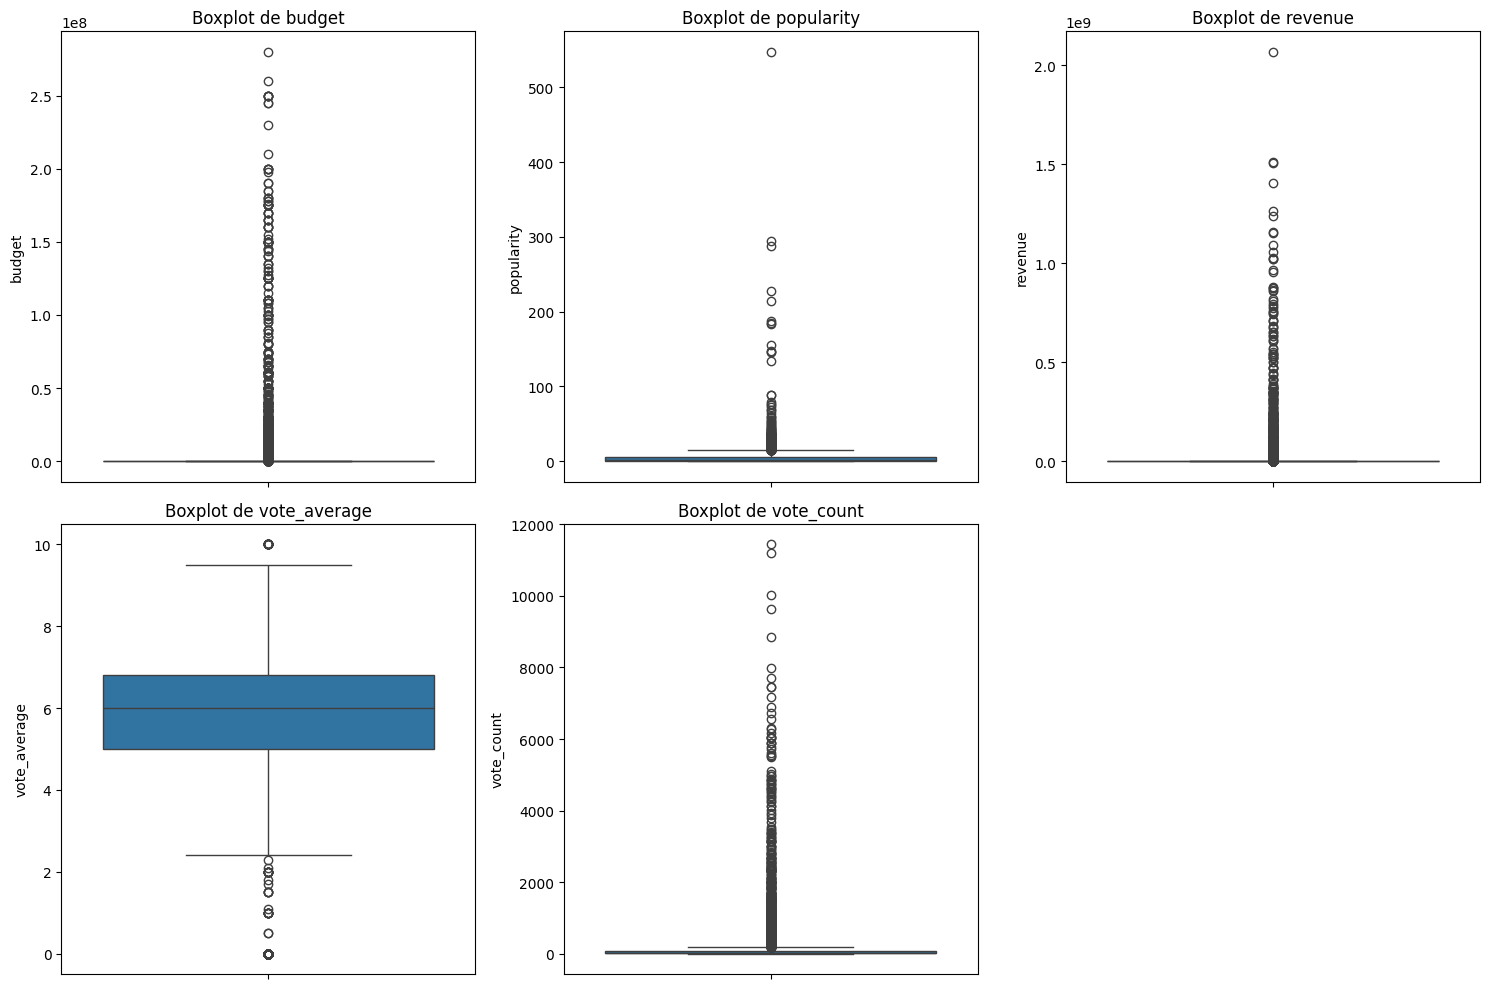

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = ['budget', 'popularity', 'revenue', 'vote_average', 'vote_count']

# Creamos un boxplot para cada columna numérica
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df_movies_recortado[column])
    plt.title(f"Boxplot de {column}")
plt.tight_layout()
plt.show()

In [15]:

# Detectamos outliers usando el rango intercuartílico (IQR)
outliers = {}
for column in numeric_columns:
    Q1 = df_movies_recortado[column].quantile(0.25)
    Q3 = df_movies_recortado[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[column] = df_movies_recortado[(df_movies_recortado[column] < lower_bound) | (df_movies_recortado[column] > upper_bound)][column]

# Mostramos el número de outliers por columna
for column, values in outliers.items():
    print(f"Outliers en {column}: {len(values)} valores")

Outliers en budget: 961 valores
Outliers en popularity: 290 valores
Outliers en revenue: 832 valores
Outliers en vote_average: 334 valores
Outliers en vote_count: 721 valores


Con los graficos y cantidad de outliers vemos que en la mayoria de columnas vemos una gran concentración en valores bajos, a excepcion de vote_average, por lo que se observan muchos outliers hacia valores altos.

Pero dada la naturaleza del dataframe, que se trate de películas, esto es común ya que existen algunas películas que se destacan en popularidad, ingresos y presupuestos.

Como nuestra consigna es entrenar un modelo de recomendación basado principalmente en la similitud de puntuación (popularity), ahora vamos a buscar la relacion entre popularity y algunas variables numericas relevantes

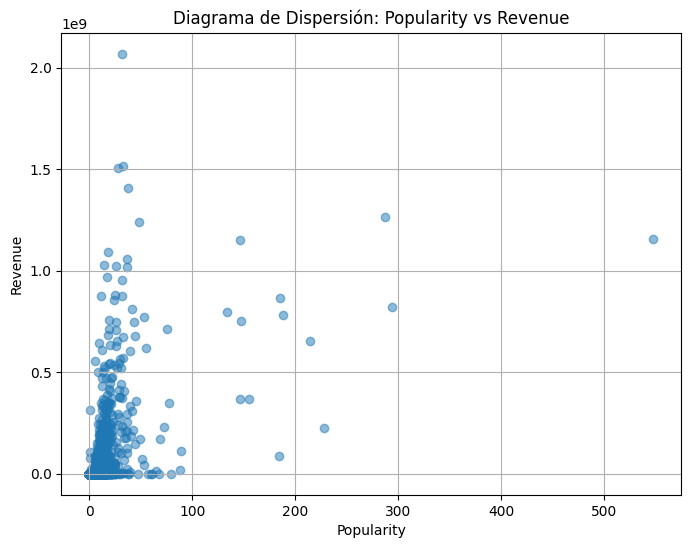

In [16]:
# Creamos un diagrama de dispersión entre popularity y revenue
plt.figure(figsize=(8, 6))
plt.scatter(df_movies_recortado['popularity'], df_movies_recortado['revenue'], alpha=0.5)
plt.title("Diagrama de Dispersión: Popularity vs Revenue")
plt.xlabel("Popularity")
plt.ylabel("Revenue")
plt.grid()
plt.show()

No se ve una clara correlacion entre la popularidad y las ganancias

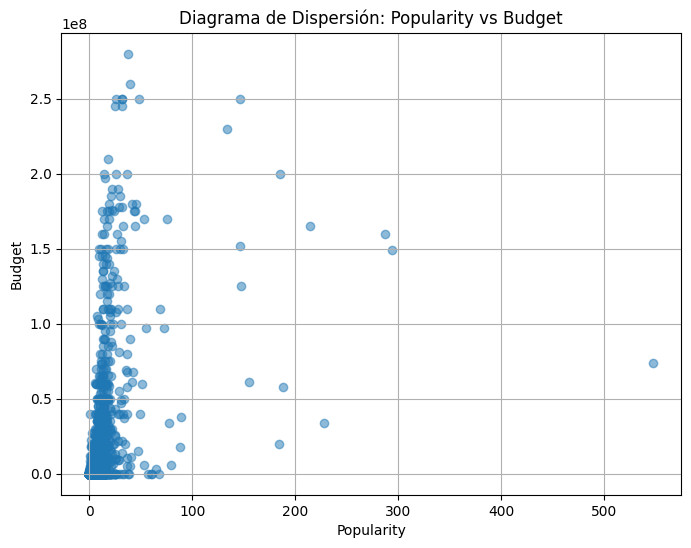

In [17]:
# Creamos un diagrama de dispersión entre popularity y budget
plt.figure(figsize=(8, 6))
plt.scatter(df_movies_recortado['popularity'], df_movies_recortado['budget'], alpha=0.5)
plt.title("Diagrama de Dispersión: Popularity vs Budget")
plt.xlabel("Popularity")
plt.ylabel("Budget")
plt.grid()
plt.show()

No se ve una correlacion directa entre la popularidad y el presupuesto

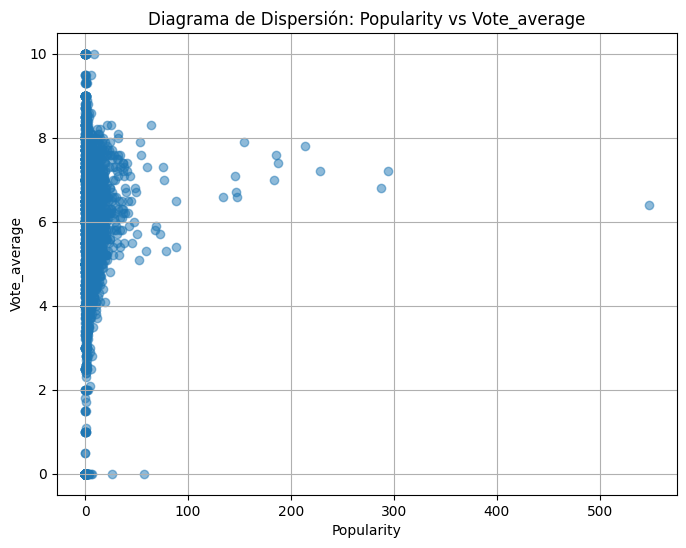

In [18]:
# Creamos un diagrama de dispersión entre popularity y vote_average
plt.figure(figsize=(8, 6))
plt.scatter(df_movies_recortado['popularity'], df_movies_recortado['vote_average'], alpha=0.5)
plt.title("Diagrama de Dispersión: Popularity vs Vote_average")
plt.xlabel("Popularity")
plt.ylabel("Vote_average")
plt.grid()
plt.show()

Aqui se esperaría que haya una correlacion entre popularidad y votos promedio, sin embargo vemos que la popularidad de una película no siempre está relacionada con su calificación.

Creo que ya analizamos las variables numericas que podrian tener relacion con la popularidad. Ahora vamos a explorar las variables de cadena. 

popularity         1.000000
Action             0.163431
Family             0.083186
Adventure          0.079495
Science Fiction    0.027464
Crime              0.018830
Mystery            0.017076
Fantasy            0.008964
War                0.007691
Thriller           0.002266
Horror             0.001920
Animation          0.000066
Drama             -0.001830
Western           -0.003297
History           -0.007786
Romance           -0.024073
Music             -0.024281
TV Movie          -0.026319
Comedy            -0.044615
Documentary       -0.112034
Name: popularity, dtype: float64


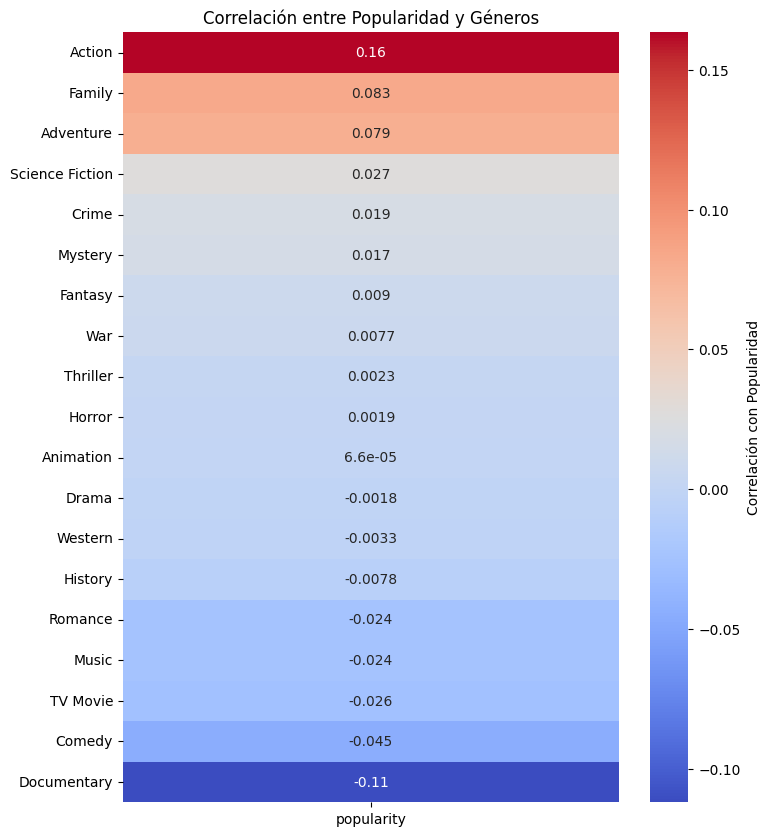

In [19]:

# Dividir los géneros y expandirlos a columnas binarias
df_genres = df_movies_recortado['genre'].str.get_dummies(sep='|')
df_popularity_genres = pd.concat([df_movies_recortado['popularity'], df_genres], axis=1)

# Calcular la correlación
correlations = df_popularity_genres.corr()['popularity'].sort_values(ascending=False)
print(correlations)

plt.figure(figsize=(8, 10))
sns.heatmap(correlations[1:].to_frame(), annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlación con Popularidad'})
plt.title('Correlación entre Popularidad y Géneros')
plt.show()

La mayoría de los géneros tienen una correlación muy baja con la popularidad. Por lo que el género de una película no tiene una gran influencia en su popularidad, al menos no en este dataset.

Pasamos a explorar el campo Overview. Vamos a transformar los datos para poder analizarlos.

Primero, creamos una nube de palabras para ver si hay palabras comunes y a traves de las mismas tambien podemos lograr identificar similitudes entre peliculas

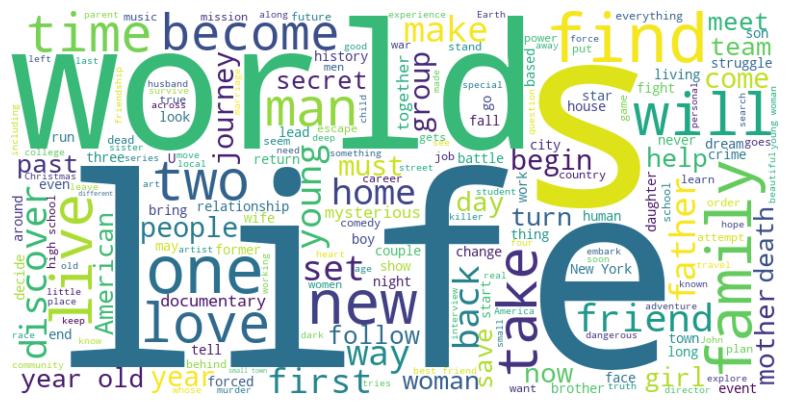

In [20]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Unir todos los textos de 'overview' en un solo string
text = " ".join(overview for overview in df_movies_recortado['overview'].dropna())

# Definir palabras irrelevantes
stopwords = set(STOPWORDS)
stopwords.update(["movie", "film", "story"])  # Puedes agregar más palabras aquí

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Vemos que existen palabras comunes destacadas entre las peliculas, esto puede aportar información útil para mejorar la recomendación.

Vamos a usar técnicas de procesamiento de lenguaje natural para convertir los overviews en vectores de características y luego incluirlos en el análisis de similitud.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Nos asegurarmos de que la columna 'overview' no tenga valores nulos
df_movies_recortado['overview'] = df_movies_recortado['overview'].fillna('')

# Creamos el vectorizador TF-IDF (se eliminan las palabras comunes en inglés con 'stop_words')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Transformamos los resúmenes en una matriz TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(df_movies_recortado['overview'])

# En la matriz TF-IDF cada fila representa una película y cada columna una palabra
print(f"Forma de la matriz TF-IDF: {tfidf_matrix.shape}")

# Calculamos la similitud de coseno entre los vectores de TF-IDF
overview_similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# La matriz de similitud tiene una forma de (n_películas, n_películas)
print(f"Forma de la matriz de similitud: {overview_similarity_matrix.shape}")

Forma de la matriz TF-IDF: (4384, 19649)
Forma de la matriz de similitud: (4384, 4384)


Luego utilizaremos esta matriz para la recomendación final

Ahora, calcularemos la matriz de similitud en base a la popularidad

In [24]:
# Aplicamos la funcion describe en la columna popularity 
print(df_movies_recortado['popularity'].describe())

count    4384.000000
mean        5.143038
std        14.865454
min         0.012941
25%         0.603756
50%         1.810389
75%         6.133339
max       547.488298
Name: popularity, dtype: float64


Vemos en la descripcion anterior lo que tambien verificamos en los graficos de bigote mas arriba: que los valores de popularidad se encuentran muy concentrados y hay que tener en cuenta que la similitud del coseno funciona mejor cuando los valores estan mas dispersos o bien, cuando se tienen múltiples características que comparan las películas, ya que te da una idea más compleja de cuán similares son las películas entre sí.

Dicho esto, aunque verificamos que no existe una correlacion directa entre popularity y las demas columnas numericas, agregarlas nos aportara una mayor complejidad para realizar las comparaciones. Agregaremos al analisis los valores de vote_average

In [84]:
# Resetearemos el indice de movies
df_movies_recortado.reset_index(drop=True, inplace=True)

# Seleccionar las columnas a utilizar en el analisis
columnas_a_usar = ['popularity', 'vote_average']
columnas_renombradas = ['popularity_norm', 'vote_average_norm']

#Eliminaremos los valores nulos de las columnas ya que ese paso es necesario para la matriz
df_movies_recortado = df_movies_recortado.dropna(subset=columnas_a_usar)

In [57]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalizar las columnas seleccionadas
scaler = MinMaxScaler()
df_movies_recortado[columnas_renombradas] = scaler.fit_transform(df_movies_recortado[columnas_a_usar])

# Crear una matriz con las columnas normalizadas
matriz_caracteristicas = df_movies_recortado[columnas_renombradas].values

In [58]:

import tracemalloc

tracemalloc.start()

# Calculamos la similitud de coseno entre las películas usando varias características y medimos el consumo en memoria
popularity_similarity_matrix = cosine_similarity(matriz_caracteristicas)
print(f"Forma de la matriz de similitud: {popularity_similarity_matrix.shape}")

tracemalloc.get_traced_memory()

print(f"Consumo de memoria {(tracemalloc.get_traced_memory()[1]-tracemalloc.get_traced_memory()[0])/125000}")

tracemalloc.stop()

Forma de la matriz de similitud: (4384, 4384)
Consumo de memoria 0.58648


In [59]:
print(popularity_similarity_matrix)

[[1.00000000e+00 9.99998692e-01 9.99993783e-01 ... 9.99894004e-01
  9.99531192e-01 3.11965468e-02]
 [9.99998692e-01 1.00000000e+00 9.99986772e-01 ... 9.99869147e-01
  9.99579406e-01 2.95798522e-02]
 [9.99993783e-01 9.99986772e-01 1.00000000e+00 ... 9.99939126e-01
  9.99417021e-01 3.47207170e-02]
 ...
 [9.99894004e-01 9.99869147e-01 9.99939126e-01 ... 1.00000000e+00
  9.98979478e-01 4.57457012e-02]
 [9.99531192e-01 9.99579406e-01 9.99417021e-01 ... 9.98979478e-01
  1.00000000e+00 5.79911849e-04]
 [3.11965468e-02 2.95798522e-02 3.47207170e-02 ... 4.57457012e-02
  5.79911849e-04 1.00000000e+00]]


Vemos que la matriz presenta valores diferenciados, lo cual nos ayudara a diferenciarlos y a medir sus similitudes al mismo tiempo

Ahora mediremos el consumo de memoria al combinar las matrices de similitud de popularidad(+otros) y overview

In [66]:
#Volvemos a correr la generacion de la matriz TF-IDF ya que el numero de registros se ha reducido

df_movies_recortado['overview'] = df_movies_recortado['overview'].fillna('')

# Transformamos los resúmenes en una matriz TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(df_movies_recortado['overview'])

# En la matriz TF-IDF cada fila representa una película y cada columna una palabra
print(f"Forma de la matriz TF-IDF: {tfidf_matrix.shape}")

# Calculamos la similitud de coseno entre los vectores de TF-IDF
overview_similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# La matriz de similitud tiene una forma de (n_películas, n_películas)
print(f"Forma de la matriz de similitud: {overview_similarity_matrix.shape}")

Forma de la matriz TF-IDF: (4384, 19649)
Forma de la matriz de similitud: (4384, 4384)


In [67]:
# Asignar pesos a cada matriz
peso_popularidad = 0.7
peso_overview = 0.3

import tracemalloc
tracemalloc.start()
# Matriz combinada de similitud
combined_similarity_matrix = (peso_popularidad * popularity_similarity_matrix) + (peso_overview * overview_similarity_matrix)
print(f"Forma de la matriz de similitud: {popularity_similarity_matrix.shape}")

tracemalloc.get_traced_memory()

print(f"Memoria:{(tracemalloc.get_traced_memory()[1]-tracemalloc.get_traced_memory()[0])/125000}")

tracemalloc.stop()

Forma de la matriz de similitud: (4384, 4384)
Memoria:1230.032528


Como vemos, utilizar el analisis de similitud de palabras de overview para la recomendación hace que se lleve un tiempo considerable para el proceso, por lo que lastimosamente debido a los recursos limitados que tendremos en nuestra herramienta (Render), utilizaremos solamente la matriz de popularidad.

In [68]:
def recomendacion(titulo):
    
    # Verificar si el título existe en el dataset
    if titulo not in df_movies_recortado['title'].values:
        return f"La película '{titulo}' no se encuentra en el dataset."

    # Encontrar el índice de la película en el dataset
    movie_index = df_movies_recortado[df_movies_recortado['title'] == titulo].index[0]
    
    # Obtener los puntajes de similitud para esa película específica
    similarity_scores = list(enumerate(popularity_similarity_matrix[movie_index]))
    
    # Ordenar las películas por similitud en orden descendente
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Seleccionar los índices de las películas más similares (excluyendo la misma película)
    top_movies_indices = [i[0] for i in similarity_scores[1:6]]
    
    # Filtrar y ordenar las películas similares por popularidad
    top_movies = df_movies_recortado.iloc[top_movies_indices]
    top_movies = top_movies.sort_values(by='popularity', ascending=False)
    
    # Obtener los títulos de las películas recomendadas
    recommended_titles = top_movies['title'].tolist()
    
    return recommended_titles

In [70]:
#Probamos la funcion
titulo = 'Wonder Woman' 
recomendaciones = recomendacion(titulo)
print("Películas recomendadas:", recomendaciones)

Películas recomendadas: ['Beauty and the Beast', 'Baby Driver', 'Big Hero 6', 'Deadpool', 'John Wick']


Ahora hagamos una breve validacion de la recomendacion, verificando si las peliculas tienen un popularidad similar

In [71]:
print(f"Popularidad titulo principal: {df_movies_recortado[df_movies_recortado['title'] == titulo]['popularity'].values[0]}")

# Imprimir popularidad de cada recomendación
for title in recomendaciones:
    print(f"Recomendada: {title} - Popularidad: {df_movies_recortado[df_movies_recortado['title'] == title]['popularity'].values[0]}")

Popularidad titulo principal: 294.337037
Recomendada: Beauty and the Beast - Popularidad: 287.253654
Recomendada: Baby Driver - Popularidad: 228.032744
Recomendada: Big Hero 6 - Popularidad: 213.849907
Recomendada: Deadpool - Popularidad: 187.860492
Recomendada: John Wick - Popularidad: 183.870374


Nuestra funcion devuelve correctamente 5 peliculas con popularidad similar y en orden descendente. Ahora llevamos la logica de la funcion en el main, para lo cual, exportaremos los datos normalizados de popularity

In [75]:
print(matriz_caracteristicas.shape)
print(matriz_caracteristicas)

(4384, 2)
[[1.62301040e-02 5.20000000e-01]
 [1.80516089e-02 6.10000000e-01]
 [2.04975820e-02 5.90000000e-01]
 ...
 [3.80087226e-02 8.30000000e-01]
 [2.31964779e-04 4.00000000e-01]
 [2.74120101e-04 0.00000000e+00]]


In [77]:
import pyarrow as pa
import pyarrow.parquet as pq

columnas = [pa.array(matriz_caracteristicas[:, i]) for i in range(matriz_caracteristicas.shape[1])]

# Asignamos nombres a cada columna
column_names = [f"col_{i}" for i in range(matriz_caracteristicas.shape[1])]

# Crear una tabla de PyArrow y guardar en formato Parquet
matriz_normalizada_popularity_pa = pa.Table.from_arrays(columnas, names=column_names)
pq.write_table(matriz_normalizada_popularity_pa, "matriz_normalizada_popularity.parquet")

DATASET PARA LAS FUNCIONES. Crearemos bases resumidas a partir del dataframe recortado segun cada funcion que debe tener nuestra API

In [86]:
#Para la funcion cantidad_filmaciones_mes, contamos las películas por mes de lanzamiento
cant_pelis_x_mes = df_movies_recortado.groupby('release_month')['movie_id'].nunique().reset_index()

# Renombramos las columnas para mayor claridad
cant_pelis_x_mes.columns = ['release_month', 'movie_count']

cant_pelis_x_mes = cant_pelis_x_mes.sort_values(by='release_month')
print(cant_pelis_x_mes)
# Vemos el DataFrame resultante
resumen(cant_pelis_x_mes)

    release_month  movie_count
0               1          406
1               2          304
2               3          421
3               4          487
4               5          343
5               6          360
6               7          287
7               8          338
8               9          426
9              10          486
10             11          304
11             12          222
data shape: (12, 2)


,data type,#missing,%missing,#unique
release_month,int32,0,0.0,12
movie_count,int64,0,0.0,11


In [89]:
# Creamos una la columna release_day que contenga el dia de la columna 'release_date'
df_movies_recortado['release_day'] = df_movies_recortado['release_date'].dt.day_name()

In [91]:
#Para la funcion cantidad_filmaciones_dia, contamos las películas por mes de lanzamiento
cant_pelis_x_dia = df_movies_recortado.groupby('release_day')['movie_id'].nunique().reset_index()

# Renombramos las columnas para mayor claridad
cant_pelis_x_dia.columns = ['release_day', 'movie_count']

cant_pelis_x_dia = cant_pelis_x_dia.sort_values(by='release_day')
print(cant_pelis_x_dia)
# Vemos el DataFrame resultante
resumen(cant_pelis_x_dia)

  release_day  movie_count
0      Friday         1570
1      Monday          311
2    Saturday          511
3      Sunday          342
4    Thursday          727
5     Tuesday          487
6   Wednesday          436
data shape: (7, 2)


,data type,#missing,%missing,#unique
release_day,object,0,0.0,7
movie_count,int64,0,0.0,7


In [92]:
# Para varias funciones (score_titulo, votos_titulos, get_actor, get_director), filtramos las columnas que usaremos y eliminamos filas duplicadas para tener los valores distintos
peliculas_datos = df_movies_recortado[['movie_id','title', 'budget', 'revenue','release_year', 'release_date', 'popularity', 'vote_count', 'vote_average', 'return']].drop_duplicates()

# Vemos el head del DataFrame resultante
print(peliculas_datos.head())
peliculas_datos.shape

   movie_id                                 title    budget      revenue  \
0  227348.0  Paranormal Activity: The Marked Ones   5000000   86362372.0   
1  168530.0                            Ride Along  25000000  153997819.0   
2  137094.0             Jack Ryan: Shadow Recruit  60000000   50549107.0   
3  157350.0                             Divergent  85000000  288747895.0   
4  217993.0                   Justice League: War   3500000    5155325.0   

   release_year release_date  popularity  vote_count  vote_average     return  
0          2014   2014-01-01    8.898523       455.0           5.2  17.272474  
1          2014   2014-01-07    9.895752       867.0           6.1   6.159913  
2          2014   2014-01-15   11.234862      1194.0           5.9   0.842485  
3          2014   2014-03-14   21.572585      4784.0           6.9   3.397034  
4          2014   2014-02-02    8.138622       234.0           7.0   1.472950  


(4384, 10)

Ahora cargaremos y limitaremos la base credits a los registros que solamente esten en la base movies

In [93]:
#Cargaremos el dataset Credits ya desanidado en la notebook MS_transformaciones para crear los datasets de las demas funciones
df_credits = pd.read_parquet('../Datasets/df_credits_desanidado.parquet')

In [94]:
# Filtrar el DataFrame de credits para incluir solo las peliculas que existen en el DataFrame de movies
df_credits = df_credits[df_credits['movie_id'].isin(df_movies_recortado['movie_id'])]


In [95]:
# Para la funcion get_actor filtramos el DataFrame para obtener solo las columnas necesarias, y eliminar valores NaN en 'actor_id' y 'actor_name'
actores_df = df_credits[['movie_id', 'actor_id', 'actor_name']].dropna(subset=['actor_id', 'actor_name'])

# Eliminamos duplicados para evitar registros repetidos de actores en cada película
actores_df = actores_df.drop_duplicates()

# Vemos el head del DataFrame resultante
print(actores_df.head())
actores_df.shape

        movie_id   actor_id           actor_name
297781    235271    80758.0         Boris Kodjoe
297782    235271  1374148.0     Brandon Gonzales
297783    235271  1374149.0        Cameron Mills
297784    235271   929826.0  Emayatzy Corinealdi
297785    235271  1374150.0        Garrett Hines


(61634, 3)

In [96]:
print(actores_df[actores_df["actor_id"]==31])


        movie_id  actor_id actor_name
366051    256835      31.0  Tom Hanks
405072    253639      31.0  Tom Hanks
448111    339988      31.0  Tom Hanks
448286    296098      31.0  Tom Hanks
489917    356325      31.0  Tom Hanks
496255    270010      31.0  Tom Hanks
506903    363676      31.0  Tom Hanks
522062    207932      31.0  Tom Hanks
544069    305642      31.0  Tom Hanks


In [97]:
# Para la funcion get_director, filtramos el DataFrame para obtener solo los directores (crew_job="Director") y columnas necesarias
directores_df = df_credits[(df_credits['crew_job'] == "Director")][['movie_id', 'crew_id', 'crew_name']]

# Eliminamos duplicados para cada película
directores_df = directores_df.drop_duplicates()

# Vemos el DataFrame resultante
print(directores_df.head())
directores_df.shape

        movie_id    crew_id              crew_name
261704    235271    62116.0         Bille Woodruff
278518    146015    98103.0         Richard Ayoade
282283    241765  1024823.0         Brian A Miller
282833    194188    33156.0        James Merendino
283541    227348    54248.0  Christopher B. Landon


(4882, 3)

In [98]:
#Exportamos los sub_datasets en formato parquet

cant_pelis_x_mes_parq = pa.Table.from_pandas(cant_pelis_x_mes)
pq.write_table(cant_pelis_x_mes_parq, "cant_pelis_x_mes.parquet")

cant_pelis_x_dia_parq = pa.Table.from_pandas(cant_pelis_x_dia)
pq.write_table(cant_pelis_x_dia_parq, "cant_pelis_x_dia.parquet")

peliculas_datos_parq = pa.Table.from_pandas(peliculas_datos)
pq.write_table(peliculas_datos_parq, "peliculas_datos.parquet")

actores_df_parq = pa.Table.from_pandas(actores_df)
pq.write_table(actores_df_parq, "actores.parquet")

directores_df_parq = pa.Table.from_pandas(directores_df)
pq.write_table(directores_df_parq, "directores.parquet")